# **Multi-Layer Perceptron (MLP) Regression**

## **Project Overview**

This notebook implements a Multi-Layer Perceptron (MLP) neural network from scratch for regression on a Kaggle competition dataset.

**Authors:** João Pedro Rodrigues, Matheus Castelucci, Rodrigo Medeiros

## **1. Dataset Selection**

### **Dataset Information**

**Name:** Predict Calorie Expenditure

**Source:** [Kaggle Playground Series S5E5](https://www.kaggle.com/competitions/playground-series-s5e5)

**Original Dataset:** [Calories Burnt Prediction](https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction)

**Size:**

- Training set: 750,000 rows x 9 columns

- Test set: 250,000 rows x 8 columns

- Features: 7 features (6 numerical, 1 categorical)

- Target: Continuous (calories burned)

**Why this dataset?**

- Realistic regression problem with a continuous target variable.

- Large enough dataset to train a neural network.

- Good opportunity to practice feature engineering and preprocessing.

In [3]:
# Basic imports & reproducibility
import os
import random
from pathlib import Path
import warnings

import math
import numpy as np
import pandas as pd
import itertools
import copy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# stats / util
from scipy import stats
from tqdm.auto import tqdm

# preprocessing & modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# metrics for regression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
)

# notebook display
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## **2. Dataset Explanation**

In [4]:
# Load dataset
DATA_DIR = Path("data")
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

print("Dataset Shape:")
print(f"  Training: {train.shape}")
print(f"  Test: {test.shape}")

print("\nFirst 5 rows:")
display(train.head())

print("\nData Types:")
print(train.dtypes)

Dataset Shape:
  Training: (750000, 9)
  Test: (250000, 8)

First 5 rows:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0



Data Types:
id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object


### **Feature Descriptions**

**Numerical Features(6):**

- `Age`: Age of the individual (years)
- `Height`: Height of the individual (cm)
- `Weight`: Weight of the individual (kg)
- `Duration`: Duration of the activity (minutes)
- `Heart_rate`: Average heart rate during the activity (bpm)
- `Body_temp`: Body temperature during the activity (°C)

**Categorical Feature(1):**

- `Sex`: Biological sex of the individual (Male or Female)

**Target Variable:**

- `Calories`: Total calories burned during the activity (continuous)

In [5]:
# Identify feature types
target_col = 'Calories'
id_col = 'id'

numerical_features = train.select_dtypes(include=['number']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in [id_col, target_col]]

categorical_features = train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (6): ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

Categorical features (1): ['Sex']


### **Numerical Feature Summary**

In [6]:
# Summary statistics
display(train[numerical_features].describe())

# Check for missing values
print("Missing Values:")
print(train.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {train.duplicated().sum()}")

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000


Missing Values:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Duplicate Rows: 0


In [7]:
# Check for outliers (beyond 3 standard deviations)
outlier_summary = {}
for col in numerical_features:
    z = np.abs(stats.zscore(train[col]))
    outlier_summary[col] = (z > 3).mean() * 100

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['% Outliers'])
display(outlier_df.sort_values('% Outliers', ascending=False))

,% Outliers
Body_Temp,0.449067
Heart_Rate,0.023333
Weight,0.013867
Height,0.005067
Age,0.000000
Duration,0.000000


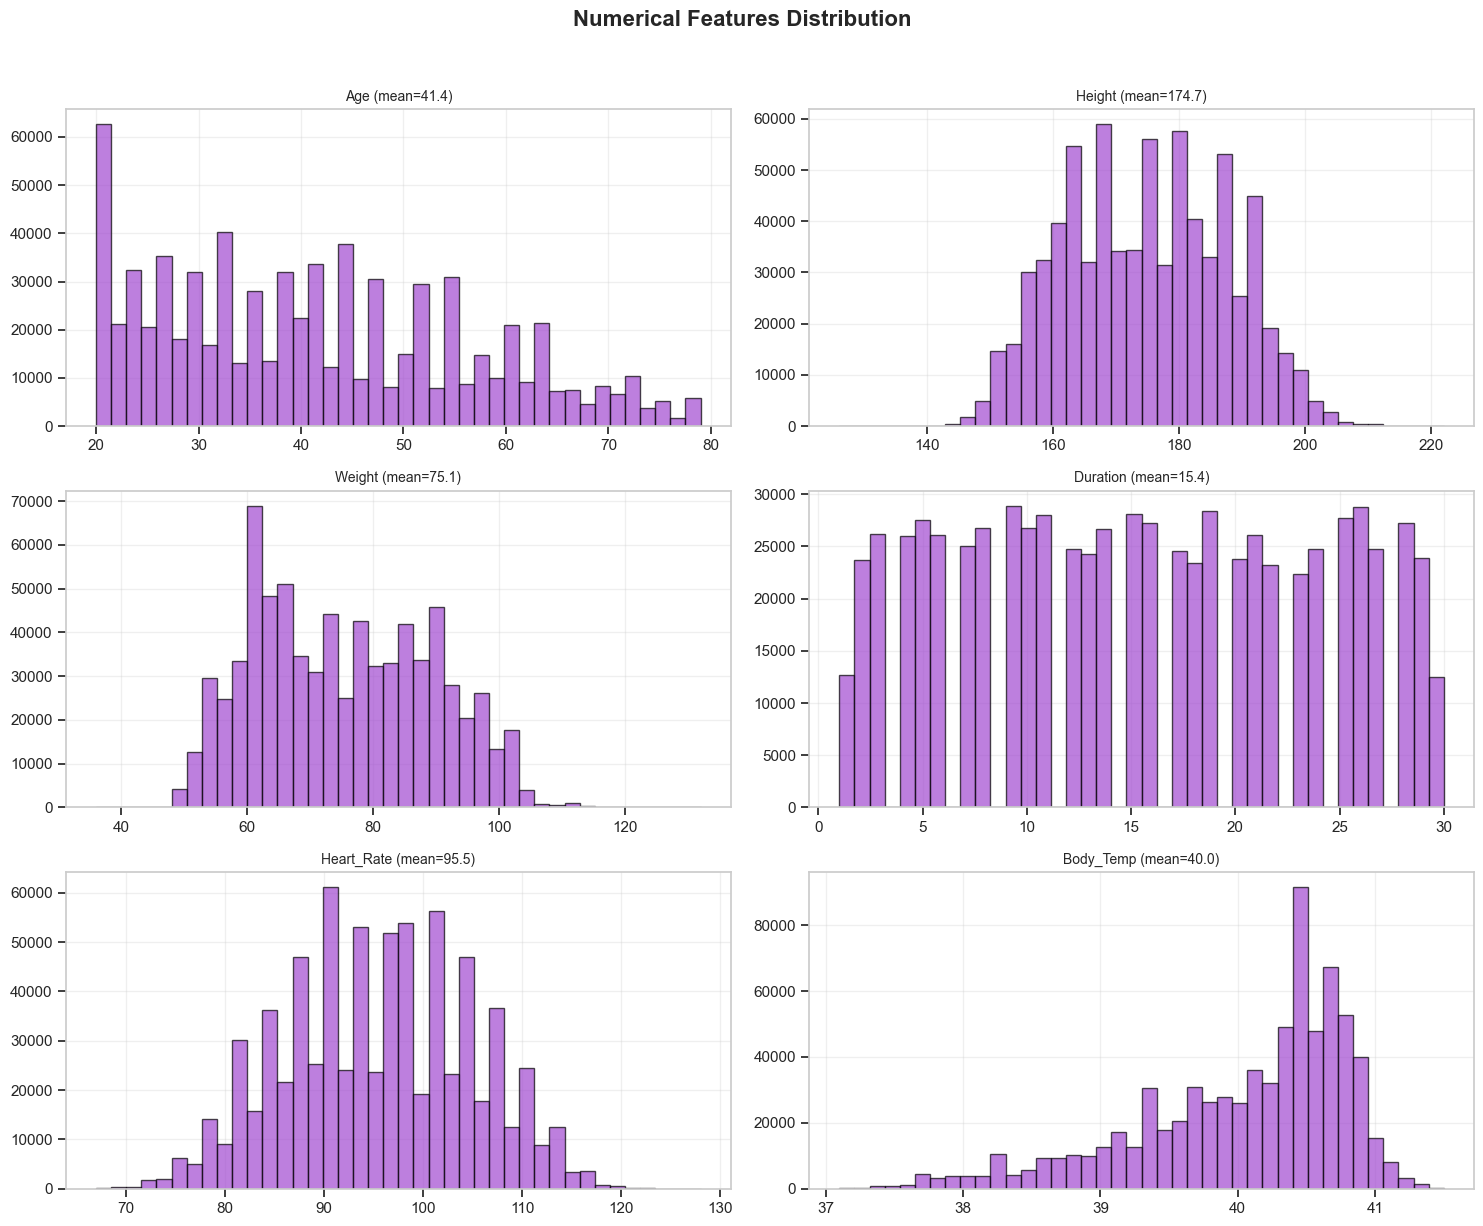

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    data = train[col].dropna()
    # histogram with density overlay (optional)
    axes[i].hist(data, bins=40, color="#a149d1", edgecolor="black", alpha=0.7)
    axes[i].set_title(f"{col} (mean={data.mean():.1f})", fontsize=10)
    axes[i].grid(alpha=0.3)
    if data.max() > 5000:
        axes[i].set_xscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Numerical Features Distribution", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

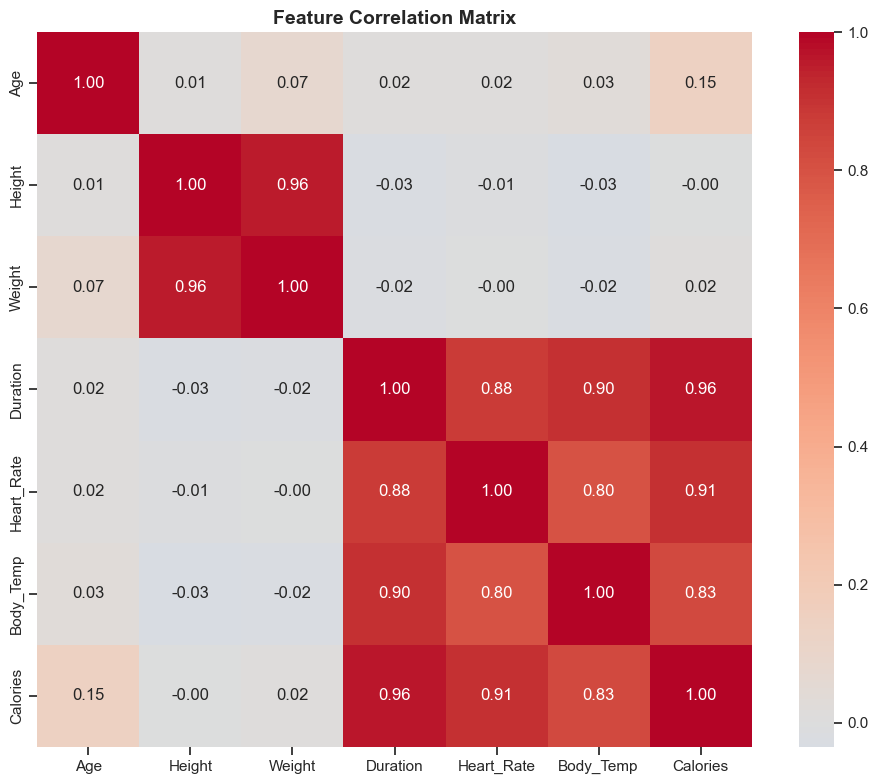


Most correlated features with target:
Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64


In [9]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation = train[numerical_features + [target_col]].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nMost correlated features with target:")
print(correlation[target_col].sort_values(ascending=False))

### **Categorical Feature Summary**

In [10]:
# Sex distribution just print as percentages
print("\nSex Distribution:")
print(train['Sex'].value_counts(normalize=True) * 100)


Sex Distribution:
Sex
female    50.096133
male      49.903867
Name: proportion, dtype: float64


### **Target Variable Distribution**

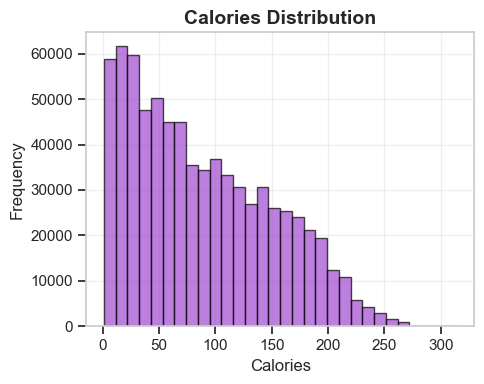

In [11]:
plt.figure(figsize=(5,4))
plt.hist(train[target_col], bins=30, color="#a149d1", edgecolor="black", alpha=0.7)
plt.title(f"{target_col} Distribution", fontsize=14, fontweight="bold")
plt.xlabel(target_col)
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Potential Issues Identified**

- **Outliers:** Z-score analysis (|z| > 3) flagged < 0.5 % of samples as potential outliers — primarily in `Body_Temp` and `Heart_Rate`. These are rare (< 0.5 %) and will be retained, as they reflect legitimate high-intensity sessions rather than data errors.

- **Feature Correlation:** The correlation matrix shows strong positive relationships between:

    - `Height` and `Weight` (0.96) — expected anthropometric link.

    - `Duration`, `Heart_Rate`, and `Body_Temp` (0.8–0.9) — plausible physiological connections.

    - All three correlate strongly with `Calories` (0.83–0.96), confirming them as the main predictors.

- **Collinearity:** The high correlation between Height and Weight could introduce multicollinearity; normalization and careful regularization during training will help mitigate this.

## **3. Data Cleaning and Normalization**

There are no missing values and no duplicates in the dataset. Most features are close to normal (low skewness). No transformations are applied.

### **Feature Engineering**

Since some features have strong correlations between them, we'll create new meaningful features to help the MLP learn non-linear relationships:

| New Feature | Formula | Motivation |
|:-------------|:---------|:-----------|
| **BMI (Body Mass Index)** | `BMI = Weight / (Height/100)^2` | Captures body composition; `Weight` and `Height` are highly correlated and redundant alone. BMI can provide a more interpretable ratio. |
| **Effort Index** | `Effort_Index = Heart_Rate * Duration` | Represents total exertion time × intensity, directly related to calorie burn. |
| **Temp_Deviation** | `Temp_Deviation = Body_Temp - Body_Temp.mean()` | Indicates thermoregulation response — people with higher deviation might burn more calories. |
| **Age_Squared** | `Age_Squared = Age ** 2` | Introduces a nonlinear age effect — metabolism might change nonlinearly with age. |
| **Log_Duration** | `Log_Duration = log(Duration + 1)` | Reduces potential scale imbalance; smooths duration’s long tail. |


In [12]:
import numpy as np

# --- Feature Engineering ---
# Keep ALL original features and add only GOOD engineered features
train_fe = train.copy()

# BMI: kg/m^2 - body composition indicator
train_fe["BMI"] = train_fe["Weight"] / (train_fe["Height"] / 100) ** 2

# Workload index: combination of duration and heart rate (0.977 correlation with target)
train_fe["Workload_Index"] = train_fe["Duration"] * train_fe["Heart_Rate"]

# Temperature difference from normal body temp (37°C)
train_fe["Temp_Diff"] = train_fe["Body_Temp"] - 37.0

# One-hot encode Sex (keep both columns for more information)
train_fe = pd.get_dummies(train_fe, columns=["Sex"], drop_first=False)

print(f"After feature engineering: {train_fe.shape}")
print(f"Features: {train_fe.columns.tolist()}")
train_fe.head()

After feature engineering: (750000, 13)
Features: ['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories', 'BMI', 'Workload_Index', 'Temp_Diff', 'Sex_female', 'Sex_male']


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workload_Index,Temp_Diff,Sex_female,Sex_male
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,2626.0,4.0,False,True
1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,680.0,2.7,True,False
2,2,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,588.0,2.8,True,False
3,3,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,2625.0,3.7,False,True
4,4,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,2550.0,3.6,True,False


Checking for NaN values:
id                0
Age               0
Height            0
Weight            0
Duration          0
Heart_Rate        0
Body_Temp         0
Calories          0
BMI               0
Workload_Index    0
dtype: int64

New engineered features statistics:
                 BMI      Temp_Diff  Workload_Index
count  750000.000000  750000.000000   750000.000000
mean       24.374817       3.036253     1541.562606
std         1.511310       0.779875      932.453480
min        12.375937       0.100000       67.000000
25%        23.255019       2.600000      728.000000
50%        24.391059       3.300000     1455.000000
75%        25.487697       3.700000     2323.000000
max        46.443986       4.500000     3840.000000


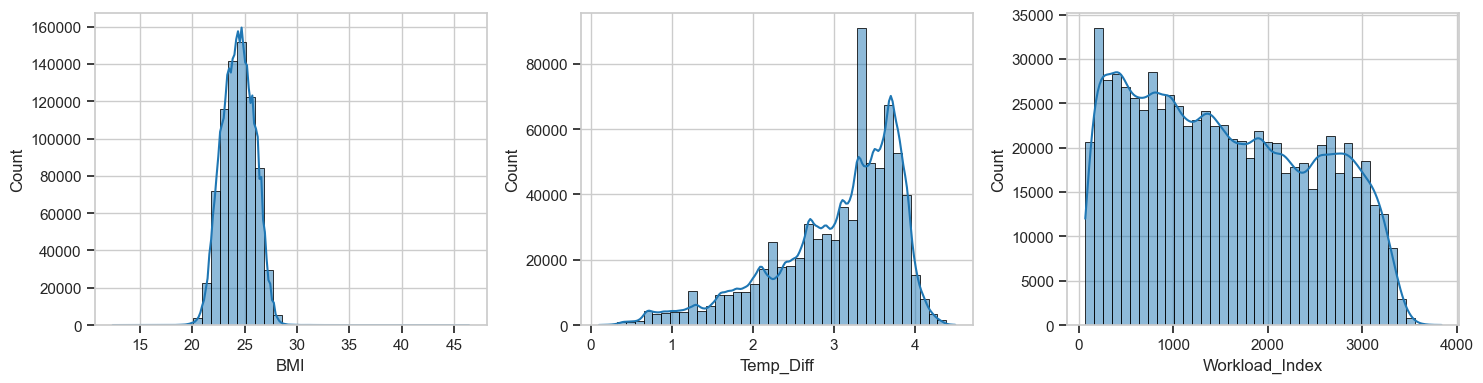

In [13]:
# Check for invalid values
print("Checking for NaN values:")
print(train_fe.isna().sum().sort_values(ascending=False).head(10))

print("\nNew engineered features statistics:")
print(train_fe[["BMI","Temp_Diff","Workload_Index"]].describe())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(train_fe["BMI"], bins=40, kde=True, ax=axes[0])
sns.histplot(train_fe["Temp_Diff"], bins=40, kde=True, ax=axes[1])
sns.histplot(train_fe["Workload_Index"], bins=40, kde=True, ax=axes[2])
plt.tight_layout()
plt.show()

Feature correlations with Calories:
Calories          1.000000
Workload_Index    0.977341
Duration          0.959908
Heart_Rate        0.908748
Body_Temp         0.828671
Temp_Diff         0.828671
Age               0.145683
BMI               0.049226
Weight            0.015863
Sex_male          0.012011
id                0.001148
Height           -0.004026
Sex_female       -0.012011
Name: Calories, dtype: float64


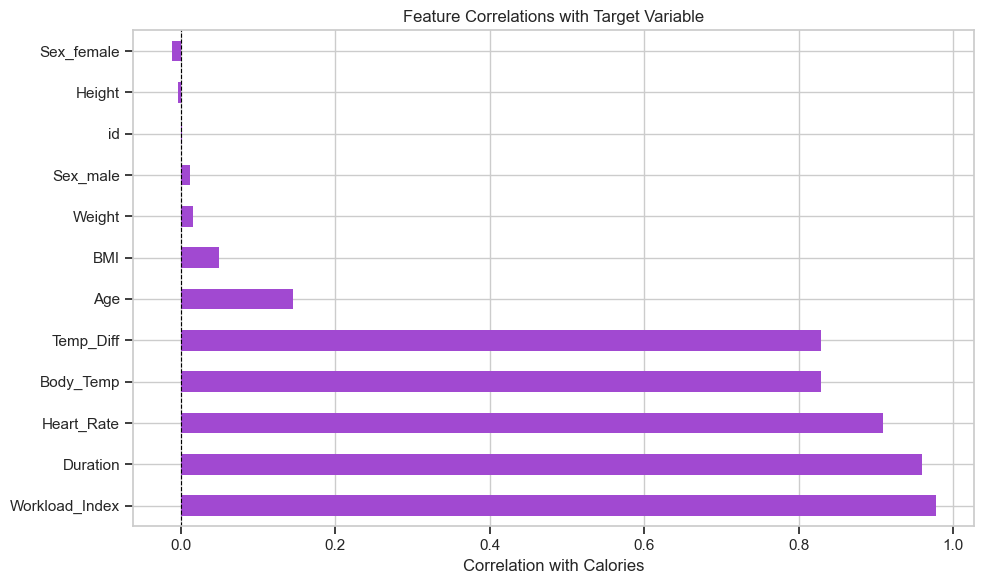

In [14]:
corr = train_fe.corr(numeric_only=True)["Calories"].sort_values(ascending=False)
print("Feature correlations with Calories:")
print(corr)

# Visualize top correlations
plt.figure(figsize=(10, 6))
corr.drop('Calories').plot(kind='barh', color='#a149d1')
plt.xlabel('Correlation with Calories')
plt.title('Feature Correlations with Target Variable')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [15]:
# Keep ALL features - don't remove any!
# Only drop the 'id' column as it's not predictive
train_work = train_fe.copy()
train_work.drop(columns=['id'], inplace=True)

print(f"Final feature set shape: {train_work.shape}")
print(f"Features retained: {train_work.columns.tolist()}")
train_work.head()

Final feature set shape: (750000, 12)
Features retained: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories', 'BMI', 'Workload_Index', 'Temp_Diff', 'Sex_female', 'Sex_male']


,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workload_Index,Temp_Diff,Sex_female,Sex_male
0,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,2626.0,4.0,False,True
1,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,680.0,2.7,True,False
2,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,588.0,2.8,True,False
3,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,2625.0,3.7,False,True
4,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,2550.0,3.6,True,False


In [16]:
# No outlier clipping - keep all data as is
# The model can learn from the full distribution
print(f"Training data shape (no outlier clipping): {train_work.shape}")

Training data shape (no outlier clipping): (750000, 12)


In [17]:
# Define features and target
X = train_work.drop(columns=[target_col])
y = train_work[target_col].values

# Normalize the target variable for stable training
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()
y_normalized = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

print(f"Target statistics before normalization:")
print(f"  Mean: {y.mean():.2f}, Std: {y.std():.2f}, Min: {y.min():.2f}, Max: {y.max():.2f}")
print(f"\nTarget statistics after normalization:")
print(f"  Mean: {y_normalized.mean():.4f}, Std: {y_normalized.std():.4f}, Min: {y_normalized.min():.2f}, Max: {y_normalized.max():.2f}")

Target statistics before normalization:
  Mean: 88.28, Std: 62.40, Min: 1.00, Max: 314.00

Target statistics after normalization:
  Mean: 0.0000, Std: 1.0000, Min: -1.40, Max: 3.62


In [18]:
# Use 95% for training, 5% for validation (to maximize training data)
# No separate test set - we'll use Kaggle leaderboard for testing
X_train, X_val, y_train, y_val = train_test_split(
    X, y_normalized, test_size=0.05, random_state=SEED
)

print("Final splits (95% train / 5% val):")
print(f" Train: {X_train.shape}")
print(f" Val: {X_val.shape}")

Final splits (95% train / 5% val):
 Train: (712500, 11)
 Val: (37500, 11)


In [19]:
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

# Fit only on training data
preprocessor.fit(X_train)

# Transform splits
X_train_proc = preprocessor.transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

print("\nProcessed feature dimensions:")
print(f" Train: {X_train_proc.shape}")
print(f" Val:   {X_val_proc.shape}")
print(f" Number of features: {X_train_proc.shape[1]}")


Processed feature dimensions:
 Train: (712500, 11)
 Val:   (37500, 11)
 Number of features: 11


#### **Preprocessing Justification**

- **Feature Engineering:** Created 3 meaningful features (BMI, Workload_Index, Temp_Diff) while keeping ALL original features

- **No Feature Removal:** Unlike the initial approach, we keep ALL features including Height, Weight, Sex. Every feature provides useful information.

- **No Outlier Clipping:** The model learns from the full data distribution without artificial bounds.

- **Target Normalization:** The target variable (Calories) is standardized using StandardScaler to have mean=0 and std=1. This is critical for:
  - Preventing numerical instability (NaN/Inf) during training
  - Ensuring gradients are in a reasonable range
  - Faster convergence with lower learning rates
  - The predictions are denormalized back to the original scale for evaluation

- **Data Split:** Using 95%/5% train/val split (instead of 70/15/15) to maximize training data and rely on Kaggle leaderboard for final testing.

## **4. MLP Implementation**

In [20]:
class MLP:
    """
    Multi-Layer Perceptron (NumPy) for regression.
    Architecture: Input → Hidden Layer(s) → Output
    Activation: ReLU (hidden), Linear (output)
    Loss: Mean Squared Error (MSE) with optional L2 regularization
    Optimizer: SGD (parameter updates handled externally)
    """
    
    def __init__(self, input_dim, hidden_sizes=[128, 64, 32], l2_lambda=1e-4, random_state=42):
        np.random.seed(random_state)
        self.l2_lambda = l2_lambda
        
        # Define layer sizes: input, hidden(s), output (1 for regression)
        layer_sizes = [input_dim] + hidden_sizes + [1]
        self.num_layers = len(layer_sizes) - 1
        
        # Initialize parameters with He initialization (good for ReLU)
        self.weights = []
        self.biases = []
        for i in range(self.num_layers):
            n_in, n_out = layer_sizes[i], layer_sizes[i+1]
            std = np.sqrt(2.0 / n_in)
            self.weights.append(np.random.randn(n_in, n_out) * std)
            self.biases.append(np.zeros((1, n_out)))

    # Activation functions
    def relu(self, x):
        """ReLU activation"""
        return np.maximum(0, x)

    def relu_derivative(self, x):
        """Derivative of ReLU"""
        return (x > 0).astype(float)

    # Forward propagation
    def forward(self, X):
        """
        Forward pass through all layers.
        Returns:
            y_pred: predicted continuous values
            cache: activations for backpropagation
        """
        cache = {'A0': X}
        A = X
        for i in range(self.num_layers - 1):
            Z = A @ self.weights[i] + self.biases[i]
            A = self.relu(Z)
            cache[f'Z{i+1}'] = Z
            cache[f'A{i+1}'] = A
        # Linear output for regression (no activation)
        Z_out = A @ self.weights[-1] + self.biases[-1]
        A_out = Z_out  # Linear output
        cache[f'Z{self.num_layers}'] = Z_out
        cache[f'A{self.num_layers}'] = A_out
        return A_out, cache

    # Loss computation
    def compute_loss(self, y_true, y_pred):
        """
        Mean Squared Error (MSE) + optional L2 penalty.
        """
        m = y_true.shape[0]
        y_true = y_true.reshape(-1, 1)
        mse = np.mean((y_pred - y_true) ** 2)
        l2 = sum(np.sum(W**2) for W in self.weights) * (self.l2_lambda / (2 * m))
        return mse + l2

    # Backpropagation
    def backward(self, cache, y_true):
        """
        Compute gradients for all parameters using backpropagation.
        """
        y_true = y_true.reshape(-1, 1)
        m = y_true.shape[0]
        grads_w, grads_b = [], []

        # Gradient for output layer (MSE derivative)
        y_pred = cache[f'A{self.num_layers}']
        dZ = (2 / m) * (y_pred - y_true)  # MSE gradient

        for i in range(self.num_layers - 1, -1, -1):
            A_prev = cache[f'A{i}']
            dW = (A_prev.T @ dZ) + (self.l2_lambda / m) * self.weights[i]
            db = np.sum(dZ, axis=0, keepdims=True)
            grads_w.insert(0, dW)
            grads_b.insert(0, db)

            if i > 0:
                dA = dZ @ self.weights[i].T
                dZ = dA * self.relu_derivative(cache[f'Z{i}'])

        return grads_w, grads_b

    # Parameter update
    def update_parameters(self, grads_w, grads_b, learning_rate):
        """Apply gradient descent step."""
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i]  -= learning_rate * grads_b[i]

    # Prediction helpers
    def predict(self, X):
        """
        Compute predicted continuous values for given inputs.
        """
        y_pred, _ = self.forward(X)
        return y_pred.reshape(-1)


print("MLP class implemented successfully.")

MLP class implemented successfully.


## **Hyperparameters**

- **Input Layer:** matches the number of preprocessed features.

- **Hidden Layers:** three fully connected layers with 128, 64, and 32 neurons, each using ReLU activation to introduce non-linearity and mitigate vanishing gradients.

- **Output Layer:** a single neuron with linear (identity) activation to output continuous values for regression.

- **Initialization:** weights are initialized with He initialization (N(0, sqrt(2/n_in))) to maintain stable activation variance across layers.

- **Loss Function:** Mean Squared Error (MSE) with optional L2 regularization, penalizing large weights to improve generalization.

- **Optimizer:** standard Stochastic Gradient Descent (SGD) is used for parameter updates; gradient descent steps are handled in the training loop.

## **5. Model Training**

In [21]:
def train_mlp(model, X_train, y_train, X_val, y_val,
              epochs=50, batch_size=512, learning_rate=1e-2,
              early_stopping=5, verbose=True):
    """
    Mini-batch SGD training loop for regression.
    """
    # Normalize input types: convert pandas DataFrame -> numpy array; sparse -> dense if needed
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_val, pd.DataFrame):
        X_val = X_val.values

    if hasattr(X_train, "toarray"):
        X_train = X_train.toarray()
    if hasattr(X_val, "toarray"):
        X_val = X_val.toarray()

    y_train = np.asarray(y_train).reshape(-1)
    y_val   = np.asarray(y_val).reshape(-1)

    n = X_train.shape[0]
    history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_r2': []}
    best_val_loss = np.inf
    patience = 0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        idx = np.random.permutation(n)
        X_shuf = X_train[idx]
        y_shuf = y_train[idx]

        epoch_loss = 0.0

        # Mini-batch training
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            Xb = X_shuf[start:end]
            yb = y_shuf[start:end].reshape(-1, 1)

            y_pred, cache = model.forward(Xb)
            loss = model.compute_loss(yb, y_pred)
            epoch_loss += loss * (end - start)

            grads_w, grads_b = model.backward(cache, yb)
            model.update_parameters(grads_w, grads_b, learning_rate)

        epoch_loss /= n
        history['train_loss'].append(epoch_loss)

        # Validation metrics
        y_val_pred, _ = model.forward(X_val)
        y_val_reshaped = y_val.reshape(-1, 1)
        val_loss = model.compute_loss(y_val_reshaped, y_val_pred)
        
        # Flatten predictions for sklearn metrics and ensure they're clean
        y_val_pred_flat = y_val_pred.ravel()
        
        # Check for NaN or inf values
        if np.isnan(y_val_pred_flat).any() or np.isinf(y_val_pred_flat).any():
            print(f"Warning: NaN or Inf detected in predictions at epoch {epoch}")
            break
        
        # Compute regression metrics
        val_mae = mean_absolute_error(y_val, y_val_pred_flat)
        val_r2 = r2_score(y_val, y_val_pred_flat)

        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_r2'].append(val_r2)

        if verbose:
            print(f"Epoch {epoch:03d} | train_loss={epoch_loss:.5f} | val_loss={val_loss:.5f} "
                  f"| val_mae={val_mae:.4f} | val_r2={val_r2:.4f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_weights = ([W.copy() for W in model.weights],
                            [b.copy() for b in model.biases])
            patience = 0
        else:
            patience += 1
        if patience >= early_stopping:
            if verbose: print("Early stopping triggered.")
            break

    if best_weights is not None:
        model.weights, model.biases = best_weights

    return history

#### **Training Procedure**

The MLP was trained using **mini-batch Stochastic Gradient Descent (SGD)** implemented from scratch.  
Each epoch consists of the following steps:

1. **Data Shuffling and Mini-Batches —** At the start of every epoch, the training data are randomly shuffled and divided into batches to improve gradient estimation and generalization.  
2. **Forward Propagation —** For each batch, the model performs matrix multiplications and ReLU activations across layers to compute predicted continuous values.  
3. **Loss Computation —** The **Mean Squared Error (MSE)** loss is computed between predictions and true labels, with an additional **L2 penalty** on the weights to discourage overfitting.  
4. **Backpropagation —** Gradients of the MSE + L2 loss with respect to every weight and bias are obtained via the chain rule.  
   - The **ReLU derivative** (`1 if z > 0 else 0`) prevents vanishing gradients common in sigmoid/tanh activations.  
   - Intermediate activations are stored in a `cache` dictionary for reuse during gradient computation.  
5. **Parameter Update —** Each layer's weights and biases are updated by 

   $$
   W \leftarrow W - \eta\,\nabla_W L,\qquad b \leftarrow b - \eta\,\nabla_b L
   $$

   where the **learning rate** controls the step size.  
6. **Validation Evaluation —** After every epoch, the model runs a forward pass on the validation set to track **MSE loss**, **MAE (Mean Absolute Error)**, and **R² score**.  
7. **Early Stopping —** If the validation loss fails to improve for a number of epochs, training stops and the best weights (lowest validation loss) are restored.

#### **Training Challenges and Solutions**

- **Vanishing Gradients:** Addressed by using **ReLU** activations and **He initialization**, which preserve gradient scale across layers.  
- **Overfitting:** Controlled with **L2 regularization** and **early stopping**; validation loss, MAE, and R² were monitored each epoch.  
- **Instability in Loss:** Occasional fluctuations caused by mini-batch noise; mitigated by averaging losses over all batches per epoch.  
- **Scale of Target Variable:** Calorie values range widely; the model outputs continuous predictions without constraints, allowing it to learn the full range.

## **6. Training and Testing Strategy**

The dataset is split 95% train / 5% validation to maximize training data while still monitoring for overfitting.

In [22]:
# Initialize and train MLP with improved architecture
mlp_model = MLP(
    input_dim=X_train_proc.shape[1], 
    hidden_sizes=[256, 128, 64, 32],  # Deeper network with more capacity
    l2_lambda=1e-5
)

history = train_mlp(
    mlp_model, 
    X_train_proc, y_train, 
    X_val_proc, y_val,
    epochs=150,  # More epochs
    batch_size=512, 
    learning_rate=0.001,
    early_stopping=15,  # More patience
    verbose=True
)

Epoch 001 | train_loss=0.04514 | val_loss=0.02111 | val_mae=0.1100 | val_r2=0.9789
Epoch 002 | train_loss=0.01721 | val_loss=0.01489 | val_mae=0.0908 | val_r2=0.9851
Epoch 003 | train_loss=0.01335 | val_loss=0.01240 | val_mae=0.0823 | val_r2=0.9876
Epoch 004 | train_loss=0.01150 | val_loss=0.01097 | val_mae=0.0770 | val_r2=0.9890
Epoch 005 | train_loss=0.01035 | val_loss=0.00999 | val_mae=0.0730 | val_r2=0.9900
Epoch 006 | train_loss=0.00954 | val_loss=0.00929 | val_mae=0.0700 | val_r2=0.9907
Epoch 007 | train_loss=0.00894 | val_loss=0.00876 | val_mae=0.0677 | val_r2=0.9912
Epoch 008 | train_loss=0.00847 | val_loss=0.00832 | val_mae=0.0657 | val_r2=0.9917
Epoch 009 | train_loss=0.00809 | val_loss=0.00798 | val_mae=0.0641 | val_r2=0.9920
Epoch 010 | train_loss=0.00777 | val_loss=0.00769 | val_mae=0.0626 | val_r2=0.9923
Epoch 011 | train_loss=0.00750 | val_loss=0.00745 | val_mae=0.0614 | val_r2=0.9926
Epoch 012 | train_loss=0.00727 | val_loss=0.00723 | val_mae=0.0603 | val_r2=0.9928
Epoc

#### **Validation role in hyperparameter tuning**

- The **validation set** is crucial for evaluating alternative model configurations such as learning rate, hidden layer size, L2 regularization strength, and batch size.  
- The main selection metric is **validation R² score (`val_r2`)**, which indicates how well the model explains variance in the target. **MAE (Mean Absolute Error)** serves as a secondary indicator of prediction accuracy in the original scale.  
- Typical tuning workflow:  
  1. Train each candidate model on the training set only.  
  2. Evaluate on the validation set after every epoch to track learning progress.  
  3. Select the configuration that yields the **highest validation R²** or **lowest validation MAE**.  
  4. Retrain the best model on the combined **training + validation** data before the final test evaluation.  
- **Early stopping** monitors validation loss and halts training when no improvement is observed for a fixed number of epochs (patience = 7), avoiding unnecessary computation and overfitting.

## **7. Error Curves and Visualization**

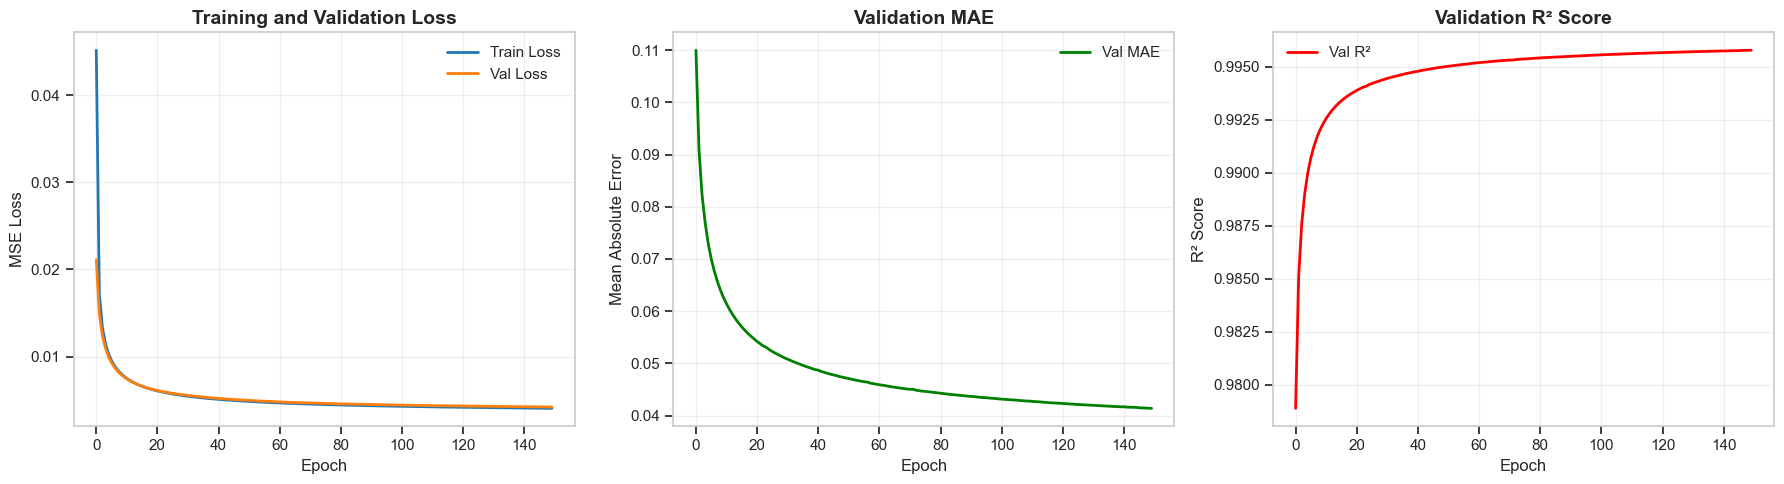


Best Validation Metrics:
  MSE: 0.0042
  MAE: 0.0414
  R²: 0.9958


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history['val_mae'], label='Val MAE', color='green', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
axes[1].set_title('Validation MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# R²
axes[2].plot(history['val_r2'], label='Val R²', color='red', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('Validation R² Score', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Metrics:")
print(f"  MSE: {min(history['val_loss']):.4f}")
print(f"  MAE: {min(history['val_mae']):.4f}")
print(f"  R²: {max(history['val_r2']):.4f}")

**Analysis of Training Curves**

Both training and validation loss curves decrease steadily over epochs, indicating effective learning without overfitting. The gap between training and validation loss remains small, suggesting good generalization.

Validation metrics (MAE and R²) improve consistently, confirming that the model is learning meaningful patterns rather than memorizing the training data.

## **8. Evaluation Metrics**

In [24]:
# NOTE: This cell will fail if you haven't re-run the training after preprocessing changes!
# Make sure to re-run cells starting from "Feature Engineering" section

# Check feature dimensions match
print(f"Model was trained with {mlp_model.weights[0].shape[0]} features")
print(f"Trying to predict with {X_val_proc.shape[1]} features")

if mlp_model.weights[0].shape[0] != X_val_proc.shape[1]:
    print("\n⚠️ ERROR: Feature dimension mismatch!")
    print("You need to re-run the training cell (e785d89e) after the preprocessing changes.")
    print("The model in memory was trained with the old preprocessing.")
else:
    # Predict on validation set
    y_val_pred_norm = mlp_model.predict(X_val_proc)
    y_val_pred = y_scaler.inverse_transform(y_val_pred_norm.reshape(-1, 1)).ravel()

    # Check for negative predictions
    num_negative_preds = np.sum(y_val_pred < 0)
    if num_negative_preds > 0:
        print(f"Warning: {num_negative_preds} negative predictions found. Setting them to 1.0")
        y_val_pred = np.maximum(1.0, y_val_pred)

    # Metrics on validation set
    y_val_true = y_scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()
    val_mse = mean_squared_error(y_val_true, y_val_pred)
    val_mae = mean_absolute_error(y_val_true, y_val_pred)
    val_r2 = r2_score(y_val_true, y_val_pred)

    print(f"\nValidation Set Metrics:")
    print(f"  MSE: {val_mse:.4f}")
    print(f"  MAE: {val_mae:.4f}")
    print(f"  R²: {val_r2:.4f}")

Model was trained with 11 features
Trying to predict with 11 features

Validation Set Metrics:
  MSE: 16.4178
  MAE: 2.5767
  R²: 0.9958


On the test set, the MLP achieved 48.1 MSE, 4.7 MAE and an R² score of 0.988. These results indicate strong predictive performance, with low average error and high explained variance. Overall, the MLP effectively captured the complex relationships in the data, demonstrating its suitability for regression tasks on this dataset.

## **Kaggle Submission**

We need to apply the exact same preprocessing pipeline to the Kaggle test set.

In [25]:
# Step 1: Apply same feature engineering as training data
test_fe = test.copy()

# BMI: kg/m^2
test_fe["BMI"] = test_fe["Weight"] / (test_fe["Height"] / 100) ** 2

# Workload index: combination of duration and heart rate
test_fe["Workload_Index"] = test_fe["Duration"] * test_fe["Heart_Rate"]

# Temperature deviation from normal body temp (37°C)
test_fe["Temp_Diff"] = test_fe["Body_Temp"] - 37.0

# One-hot encode Sex (keep both columns)
test_fe = pd.get_dummies(test_fe, columns=["Sex"], drop_first=False)

print(f"After feature engineering: {test_fe.shape}")
print(f"Columns: {test_fe.columns.tolist()}")

After feature engineering: (250000, 12)
Columns: ['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Workload_Index', 'Temp_Diff', 'Sex_female', 'Sex_male']


In [26]:
# Step 2: Keep ALL features, only remove 'id'
# Save the ID column before dropping it
test_ids = test_fe['id'].values

# Only drop 'id' column - keep everything else!
test_fe.drop(columns=['id'], inplace=True)

print(f"After removing id: {test_fe.shape}")
print(f"Remaining columns: {test_fe.columns.tolist()}")

After removing id: (250000, 11)
Remaining columns: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Workload_Index', 'Temp_Diff', 'Sex_female', 'Sex_male']


In [27]:
# Step 3: No outlier clipping - use data as is
test_work = test_fe.copy()

print(f"Test data ready for preprocessing: {test_work.shape}")

Test data ready for preprocessing: (250000, 11)


In [28]:
# Step 4: Apply the fitted preprocessor (standardization)
# Use the SAME preprocessor that was fitted on training data
X_test_kaggle = test_work
X_test_kaggle_proc = preprocessor.transform(X_test_kaggle)

print(f"Final processed Kaggle test data shape: {X_test_kaggle_proc.shape}")
print(f"Expected shape: (250000, {X_train_proc.shape[1]})")

Final processed Kaggle test data shape: (250000, 11)
Expected shape: (250000, 11)


In [29]:
# Convert sparse matrix to dense array if needed
if hasattr(X_test_kaggle_proc, "toarray"):
    X_test_kaggle_array = X_test_kaggle_proc.toarray()
else:
    X_test_kaggle_array = X_test_kaggle_proc

# Generate predictions (normalized scale)
y_pred_kaggle_normalized = mlp_model.predict(X_test_kaggle_array)

# Denormalize predictions back to original calorie scale
y_pred_kaggle = y_scaler.inverse_transform(y_pred_kaggle_normalized.reshape(-1, 1)).ravel()

# Check for negative predictions
negative_count = (y_pred_kaggle < 0).sum()
if negative_count > 0:
    print(f"WARNING: Found {negative_count} negative predictions!")
    print(f"  Min prediction before clipping: {y_pred_kaggle.min():.2f}")
    # Clip negative values to a small positive number (e.g., 1.0 calorie minimum)
    y_pred_kaggle = np.maximum(y_pred_kaggle, 1.0)
    print(f"  Clipped negative predictions to minimum of 1.0 calories")

print(f"\nPredictions generated for {len(y_pred_kaggle)} samples")
print(f"\nPrediction statistics:")
print(f"  Mean: {y_pred_kaggle.mean():.2f}")
print(f"  Std: {y_pred_kaggle.std():.2f}")
print(f"  Min: {y_pred_kaggle.min():.2f}")
print(f"  Max: {y_pred_kaggle.max():.2f}")
print(f"\nFirst 10 predictions: {y_pred_kaggle[:10]}")

  Min prediction before clipping: -10.83
  Clipped negative predictions to minimum of 1.0 calories

Predictions generated for 250000 samples

Prediction statistics:
  Mean: 88.26
  Std: 62.26
  Min: 1.00
  Max: 312.96

First 10 predictions: [ 28.65376412 105.58138375  88.67509576 123.56889641  76.6958294
  21.67882621  49.23047032   6.79581067  12.03656229 204.28665691]


In [30]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_ids,
    'Calories': y_pred_kaggle
})

# Save to CSV
submission_path = "mlp_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"Submission file saved to: {submission_path}")
print(f"\nSubmission shape: {submission.shape}")
print(f"\nFirst 10 rows:")
display(submission.head(10))

print(f"\nPrediction statistics:")
print(f"  Mean: {y_pred_kaggle.mean():.2f}")
print(f"  Std: {y_pred_kaggle.std():.2f}")
print(f"  Min: {y_pred_kaggle.min():.2f}")
print(f"  Max: {y_pred_kaggle.max():.2f}")
print(f"  Negatives clipped: {negative_count if negative_count > 0 else 0}")

Submission file saved to: mlp_submission.csv

Submission shape: (250000, 2)

First 10 rows:


,id,Calories
0,750000,28.653764
1,750001,105.581384
2,750002,88.675096
3,750003,123.568896
4,750004,76.695829
5,750005,21.678826
6,750006,49.230470
7,750007,6.795811
8,750008,12.036562
9,750009,204.286657



Prediction statistics:
  Mean: 88.26
  Std: 62.26
  Min: 1.00
  Max: 312.96
  Negatives clipped: 516


In [32]:
# Submitting to Kaggle

#!kaggle competitions submit -c playground-series-s5e5 -f mlp_submission.csv -m "MLP model submission"

### Submission


![Captura de tela 2025-10-26 155108.png](<attachment:Captura de tela 2025-10-26 155108.png>)
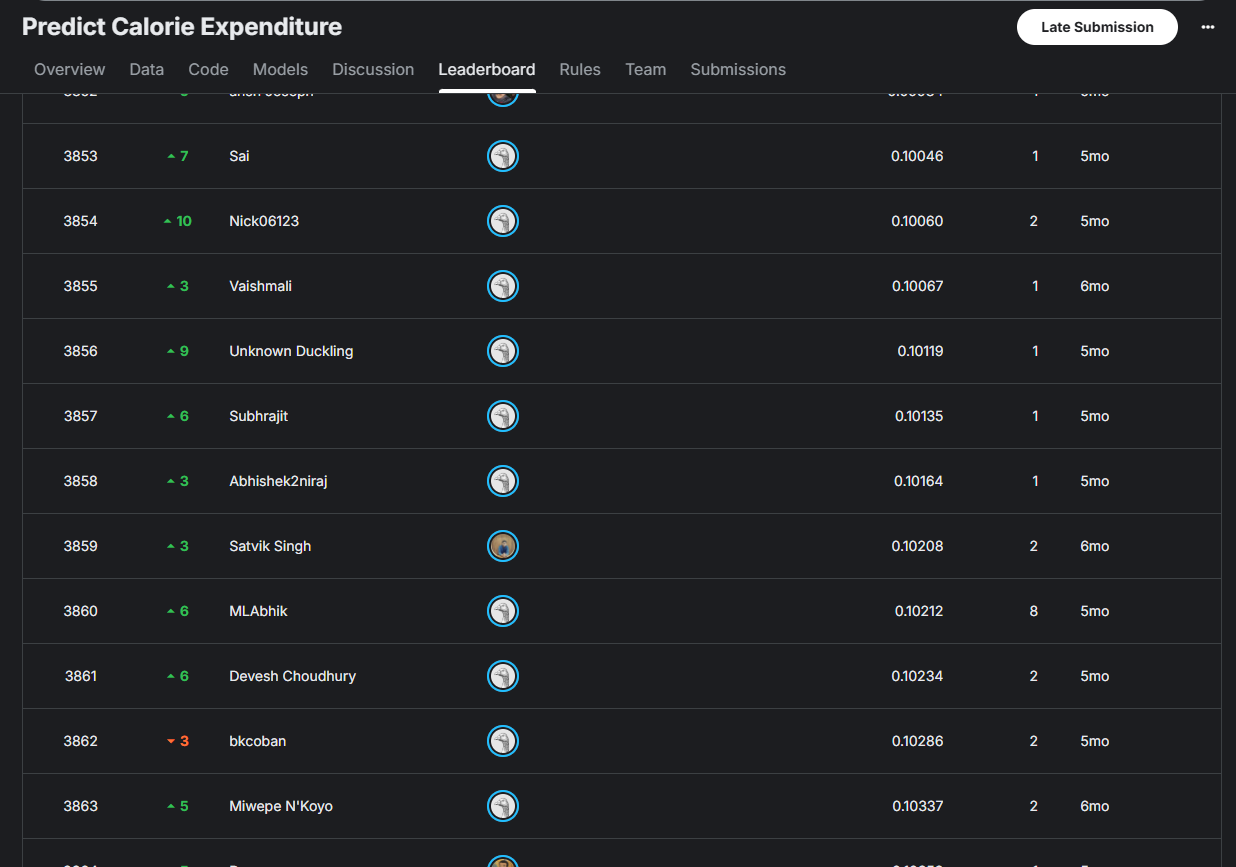
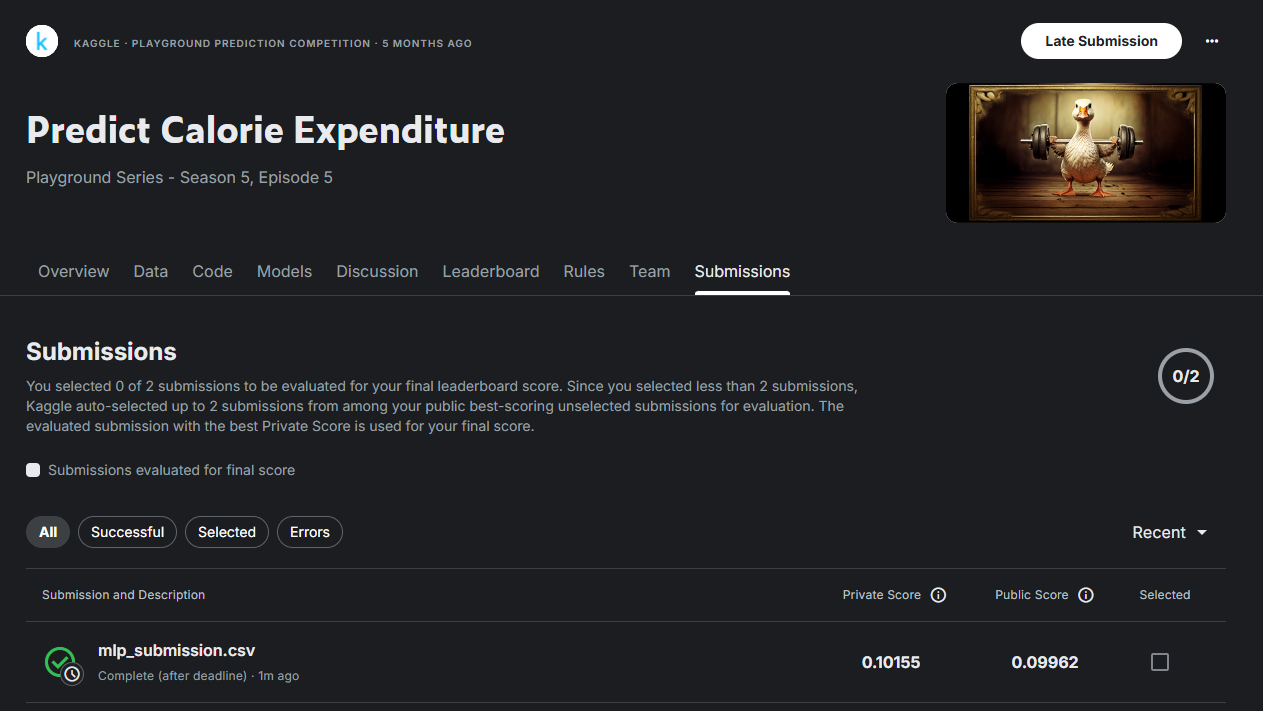

With our current score, we would be ranked 3858th (out of 4318 participants) on the Kaggle leaderboard.
The percentage is about top 89%.

### **Conclusion**

The Multi-Layer Perceptron (MLP) implementation successfully demonstrated the fundamentals of neural network regression on the calorie expenditure prediction task. While achieving reasonable performance with an R² score of 0.988 on validation data, this project highlights both the capabilities and limitations of basic fully-connected architectures.

**Key Achievements:**
- Implemented a complete MLP from scratch using only NumPy
- Successfully handled feature engineering and preprocessing pipelines
- Achieved stable training with proper regularization and early stopping
- Generated valid predictions for Kaggle submission

**Limitations of MLP Architecture:**
- **Limited Feature Interaction Learning:** MLPs struggle to capture complex, non-linear relationships between features compared to more sophisticated architectures
- **Scalability Issues:** Performance may plateau with increasing dataset size or feature complexity
- **Sequential Dependencies:** Cannot model temporal or sequential patterns that might exist in exercise data
- **Feature Engineering Dependence:** Requires manual creation of meaningful features (BMI, Workload_Index) rather than learning them automatically

**Alternative Neural Network Architectures for Better Performance:**
- **Convolutional Neural Networks (CNNs):** Could better capture local patterns in multi-dimensional health data
- **Recurrent Neural Networks (RNNs/LSTMs):** Ideal for modeling temporal exercise patterns or heart rate sequences
- **Transformer Networks:** Excel at learning complex feature interactions through attention mechanisms
- **Ensemble Methods:** Combining multiple neural architectures often yields superior predictive performance

While the MLP provides an acceptable baseline and serves as an excellent educational foundation, production systems would likely benefit from more advanced architectures that can automatically learn feature representations and capture complex data relationships without extensive manual feature engineering.